# Imports

In [1]:
import numpy as np
import oommfpy as op
import matplotlib.pyplot as plt
from pathlib import Path
import re

import matplotlib.patheffects as PathEffects

import collections

In [2]:
MagAvData = collections.namedtuple('MagAvData', ['By', 'mz_average', 'E'])

# No anisotropy

In [3]:
BYS = [-80, -100, -120]

In [4]:
mz_averages = []

BASEDIR = Path('../sims/mumax3/skyrmion_memory_device/sk_mem_dev_D_0d6e-3_A_5d7295e-12_LD_120nm.out/')
# print(list(BASEDIR.glob('*.ovf')))
# Simulation data table:
tab = np.loadtxt(BASEDIR / 'table.txt')

for by in BYS:      # mT

    FILE = BASEDIR / f'm_By_-{abs(by):06d}_mT.ovf'
    # if not FILE.exists():
    #     continue

    data = op.MagnetisationData(FILE)
    data.generate_coordinates()
    data.generate_field()
    mz_3d = data.mz.reshape(data.nz, data.ny, data.nx)

    mz_av = np.zeros((mz_3d.shape[1], mz_3d.shape[2]))
    for z_idx in range(mz_3d.shape[0]):
        mz_av += mz_3d[z_idx, :, :]

    mz_av /= mz_3d.shape[0]

    # Energy -> make a numpy mask to extract the energy from the Table
    f = np.logical_and.reduce((tab[:, -2] < 1e-5,                      # Torque
                               np.abs(tab[:, 6] - (by * 1e-3)) < 1e-4) # Field
                              )
    energy = tab[:, 4][f]

    mz_averages.append(MagAvData(By=by, mz_average=mz_av, E=energy))

    # mz_average[by] = mz_av

In [5]:
PLOTDIR = Path('skyrmion_device')
PLOTDIR.mkdir(exist_ok=True)

In [6]:
im_tubes_args = dict(vmin=-1, vmax=1, origin='lower',
                     extent=np.array([data.xmin, data.xmax, data.ymin, data.ymax]) * 1e9)

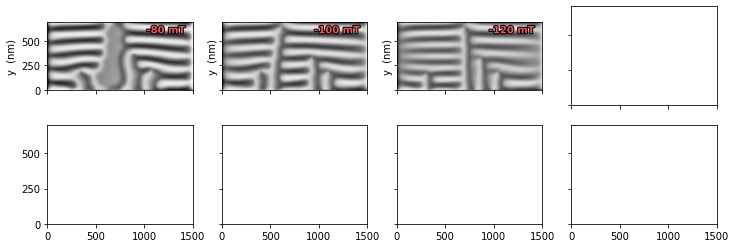

In [7]:
f, axs = plt.subplots(figsize=(12, 4), ncols=4, nrows=2, sharex=True, sharey=True)

mz_av_pick = {d.By: d.mz_average for d in mz_averages}

for b, by in enumerate(BYS):

    ax = axs.flat[b]
    ax.imshow(mz_av_pick[by], cmap='Greys', **im_tubes_args)
    # axs[b][p].set_xlabel('x  (nm)')
    # axs[b][p].set_ylabel('y  (nm)')
    # axs[b][p].set_title(f'Field: {by} mT')

    t = ax.text(0.95, 0.95, f'{by} mT', ha='right', va='top',
                transform=ax.transAxes, 
                rotation=0, color='#EB5660', fontweight='bold')

    t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    ax.set_ylabel('y  (nm)')

    if b >= 18:
        ax.set_xlabel('x  (nm)')

# plt.tight_layout()
plt.savefig(PLOTDIR / f'mz_average_field-relax.png', dpi=200, bbox_inches='tight')
plt.show()

In [32]:
print(mz_av_pick['-60'].shape)

(140, 300)


In [8]:
for b, by in enumerate(BYS):
    mz_av_pick = {str(d.By): d.mz_average for d in mz_averages}
    
np.savez(PLOTDIR / f'mz_averages_Bys.npz', **mz_av_pick)